In [13]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import astropy.units as u
from datetime import datetime
from astropy.coordinates import SkyCoord
import pickle
import json
import sys
import os
import pandas as pd
from sys import getsizeof
pd.set_option('display.max_columns', None)

# location of the scripts
sys.path.insert(0, os.path.join("/fefs/aswg/workspace/juan.jimenez/systematics/scripts"))
import auxiliar as aux
green = "#009736"
red = "#EE2A35"

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# dirs
objects_dir = "/fefs/aswg/workspace/juan.jimenez/systematics/objects"

target_name = "Crab"

# energy edges for lightcurve
e_lc_min = 100 * u.GeV
e_lc_max = 20 * u.TeV


#######################################
# intensity integration limits
#######################################

intensity_integration_lims = [100, 160] #ph


### Reading all the objects and putting all the information in a unique dict

In [2]:
%%time
###################
# reading objects
###################
# light curve data
with open(f'{objects_dir}/dict_LC.pkl', 'rb') as f:
    dict_LC = pickle.load(f)

dict_LC_2 = {}
for i, run in enumerate(np.array(dict_LC["run_number"]).astype(int)):
    tmp_dict = {
        "flux" : dict_LC["flux"][i], 
        "e_flux" : dict_LC["e_flux"][i], 
        "timestamp" : dict_LC["timestamp"][i], 
        "duration" : dict_LC["duration"][i], 
        "zd" : dict_LC["zd"][i],
        "az" : dict_LC["az"][i]
    }
    dict_LC_2[run] = tmp_dict
    
# l2 to dl3 information
with open(f"{objects_dir}/total_dict_runs.json", "r") as json_file:
    dict_dl2todl3 = json.load(json_file)
    
# load dl2 desired data
with open('objects/dict_dl2.pkl', 'rb') as f:
    dict_dl2 = pickle.load(f)
    
    
    
    
dict_runs = {}

for run in dict_dl2.keys():
    
    tmp_dict = {
        "flux" : dict_LC_2[run]["flux"].value,
        "e_flux": dict_LC_2[run]["e_flux"].value,
        "zd" : dict_LC_2[run]["zd"].value,
        "az" : dict_LC_2[run]["az"].value,
        "timestamp" : dict_LC_2[run]["timestamp"],
        "effective_time" : dict_dl2[run]["effective_time"],
    }
    
    dict_runs[run] = tmp_dict

CPU times: user 1.06 s, sys: 23.8 s, total: 24.9 s
Wall time: 1min 11s


### Time correction

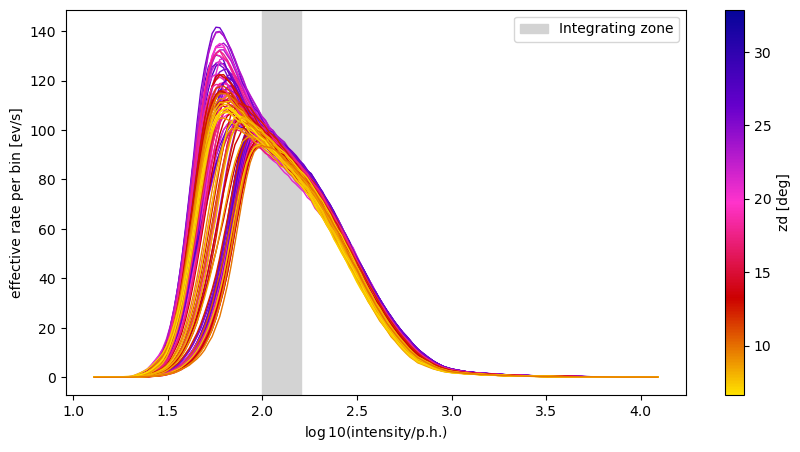

In [14]:
fig, ax = plt.subplots(figsize=(10, 5))

bins = np.linspace(1.1, 4.1, 150) 

for run in [_ for _ in dict_dl2.keys()][:]:  
    
    # getting the color of each run
    X = np.abs(dict_runs[run]["zd"] - max(dict_LC["zd"]).value) / max(dict_LC["zd"]).value
    color = aux.color_cr(X, COLORS=list(reversed(aux.predC)))

    counts, Iedges = np.histogram(np.log10(dict_dl2[run]["intensity"]), bins)
    Icenters = (Iedges[1:] + Iedges[:-1]) / 2
    counts   = counts / dict_dl2[run]["effective_time"]
    
    integral = 0
    for i, b in enumerate(bins[:-1]):
        if bins[i] > np.log10(intensity_integration_lims[0]) and bins[i+1] < np.log10(intensity_integration_lims[1]):
            integral = integral + counts[i]
    
    dict_runs[run]["p_rate"] = integral
    
    ax.plot(Icenters, counts, color=color, lw=1)

ax.axvspan(np.log10(intensity_integration_lims[0]), np.log10(intensity_integration_lims[1]), color="lightgray", label="Integrating zone")

#######################################
# creating a colorbar
cmap=aux.create_cmap(list(reversed(aux.predC)))
norm = mpl.colors.Normalize(vmin=min(dict_LC["zd"]).value, vmax=max(dict_LC["zd"]).value)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, label="zd [deg]")
#######################################

ax.legend()
ax.set_xlabel("$\log10($intensity/p.h.$)$")
ax.set_ylabel("effective rate per bin [ev/s]")
plt.show()

### Extracting all the values in arrays

In [15]:
# extracting values as arrays
p_rate   = []
e_p_rate = [] 
flux   = []
e_flux = []
zd, az = [], []
e_zd, e_az = [], []

for run in dict_runs.keys():
    flux.append(dict_runs[run]["flux"])
    e_flux.append(dict_runs[run]["e_flux"])
    zd.append(dict_runs[run]["zd"])
    az.append(dict_runs[run]["az"])
    p_rate.append(dict_runs[run]["p_rate"])
    
    _e_p_rate = np.sqrt(len(dict_dl2[run]["zd"])) / dict_runs[run]["effective_time"]
    _e_zd = np.abs(dict_dl2[run]["zd"][0] - dict_dl2[run]["zd"][-1]) / 2
    _e_az = np.abs(dict_dl2[run]["az"][0] - dict_dl2[run]["az"][-1]) / 2
    
    dict_runs[run]["e_p_rate"] = _e_p_rate
    dict_runs[run]["e_zd"] = _e_zd
    dict_runs[run]["e_az"] = _e_az
    
    e_p_rate.append(_e_p_rate)
    e_zd.append(_e_zd)
    e_az.append(_e_az)

flux   = np.array(flux)
e_flux = np.array(e_flux)
p_rate = np.array(p_rate)
zd = np.array(zd)
az = np.array(az)

### The p_rate distributions

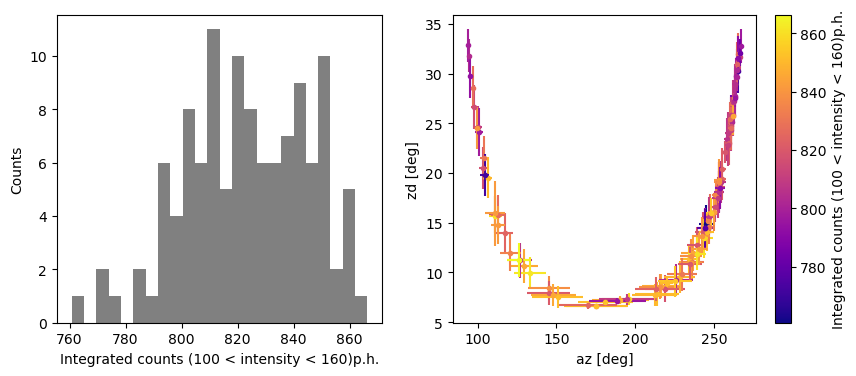

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'width_ratios': [1.2, 1.4]})

bins = np.linspace(np.min(p_rate), np.max(p_rate), 25)
ax1.hist(p_rate, bins, color="gray")

norm   = mpl.colors.Normalize(vmin=np.min(p_rate), vmax=np.max(p_rate))
colors = mpl.cm.ScalarMappable(norm,"plasma").to_rgba(p_rate)
for i in range(len(az)):
    ax2.errorbar(az[i], zd[i], xerr=e_az[i], yerr=e_zd[i], ls="", marker=".", color=colors[i])

#######################################
# creating a colorbar
sm = plt.cm.ScalarMappable(cmap="plasma", norm=norm)
sm.set_array([])
plt.colorbar(sm, label=f"Integrated counts ({intensity_integration_lims[0]} < intensity < {intensity_integration_lims[1]})p.h.")
#######################################

ax1.set_ylabel("Counts")
ax1.set_xlabel(f"Integrated counts ({intensity_integration_lims[0]} < intensity < {intensity_integration_lims[1]})p.h.")
ax2.set_xlabel("az [deg]")
ax2.set_ylabel("zd [deg]")
plt.show()

### Linearly fitting the zd to the proton rate and showing all distributions

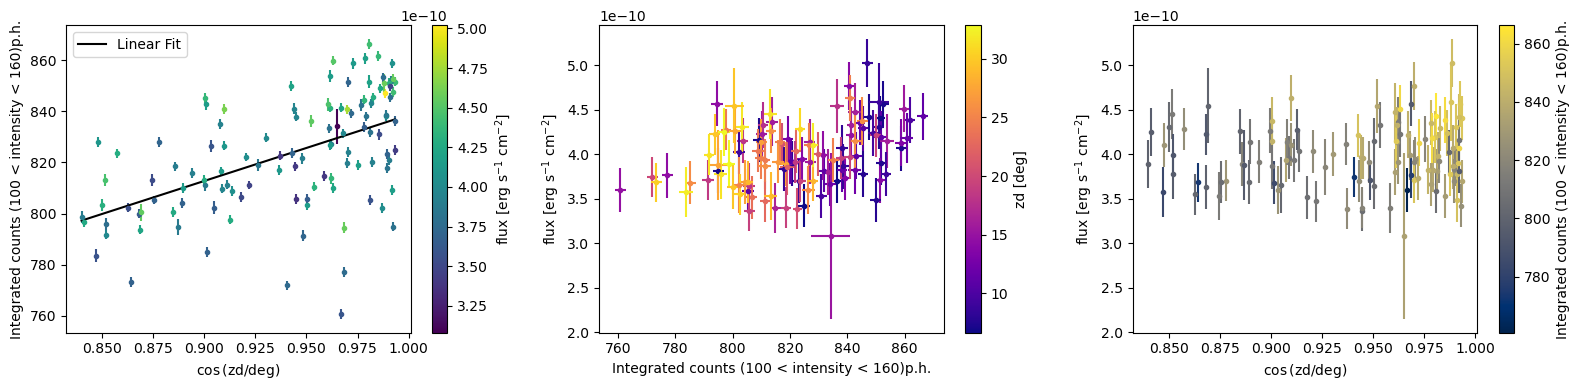

In [17]:
# Perform linear fits
fitF_zd_p = np.poly1d(np.polyfit(np.cos(np.deg2rad(zd)), p_rate, 1))    
    
############################################
# plot the figures
############################################
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))

norm_zd   = mpl.colors.Normalize(vmin=np.min(zd), vmax=np.max(zd))
colors_zd = mpl.cm.ScalarMappable(norm_zd,"plasma").to_rgba(zd)

norm_p   = mpl.colors.Normalize(vmin=np.min(p_rate), vmax=np.max(p_rate))
colors_p = mpl.cm.ScalarMappable(norm_p,"cividis").to_rgba(p_rate)

norm_f   = mpl.colors.Normalize(vmin=np.min(flux), vmax=np.max(flux))
colors_f = mpl.cm.ScalarMappable(norm_f,"viridis").to_rgba(flux)

for i in range(len(az)):
    ax1.errorbar(np.cos(np.deg2rad(zd[i])), p_rate[i], xerr=0,           yerr=e_p_rate[i], ls="", marker=".", color=colors_f[i])
    ax2.errorbar(p_rate[i],                 flux[i],   xerr=e_p_rate[i], yerr=e_flux[i],   ls="", marker=".", color=colors_zd[i])
    ax3.errorbar(np.cos(np.deg2rad(zd[i])), flux[i],   xerr=0,           yerr=e_flux[i],   ls="", marker=".", color=colors_p[i])

#######################################
# creating a colorbar
sm_zd = plt.cm.ScalarMappable(cmap="plasma",  norm=norm_zd)
sm_p  = plt.cm.ScalarMappable(cmap="cividis", norm=norm_p)
sm_f  = plt.cm.ScalarMappable(cmap="viridis", norm=norm_f)
for sm in [sm_zd, sm_p, sm_f]:
    sm.set_array([])
fig.colorbar(sm_f,  ax=ax1, label= "flux [erg s${}^{-1}$ cm${}^{-2}$]")
fig.colorbar(sm_zd, ax=ax2, label=f"zd [deg]")
fig.colorbar(sm_p,  ax=ax3, label=f"Integrated counts ({intensity_integration_lims[0]} < intensity < {intensity_integration_lims[1]})p.h.")

#######################################

####################
# plot lines
####################
zd_array = np.linspace(min(np.cos(np.deg2rad(zd))), max(np.cos(np.deg2rad(zd))), 200)
ax1.plot(zd_array, fitF_zd_p(zd_array), '-k', label="Linear Fit")


ax1.legend()
ax1.set_ylabel(f"Integrated counts ({intensity_integration_lims[0]} < intensity < {intensity_integration_lims[1]})p.h.")
ax1.set_xlabel("$\cos$(zd/deg)")
ax2.set_ylabel("flux [erg s${}^{-1}$ cm${}^{-2}$]")
ax2.set_xlabel(f"Integrated counts ({intensity_integration_lims[0]} < intensity < {intensity_integration_lims[1]})p.h.")
ax3.set_ylabel("flux [erg s${}^{-1}$ cm${}^{-2}$]")
ax3.set_xlabel(f"$\cos$(zd/deg)")

fig.tight_layout()
plt.show()

### Re-scaling the proton rate as it should be in zd=0

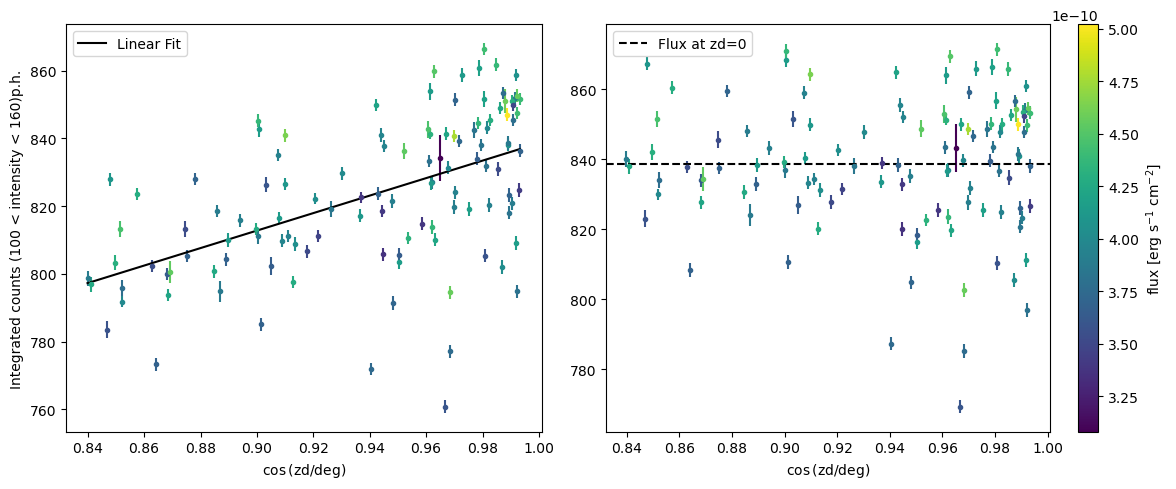

In [18]:
zd_0_p_rate = []
for run in dict_runs.keys():
    
    _zd_0_p_rate = dict_runs[run]["p_rate"] - fitF_zd_p(np.cos(np.deg2rad(dict_runs[run]["zd"]))) + fitF_zd_p(1)
    
    dict_runs[run]["zd_0_p_rate"] = _zd_0_p_rate
    zd_0_p_rate.append(_zd_0_p_rate)

    

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [1.2, 1.4]})

norm_f   = mpl.colors.Normalize(vmin=np.min(flux), vmax=np.max(flux))
colors_f = mpl.cm.ScalarMappable(norm_f,"viridis").to_rgba(flux)

for i in range(len(az)):
    ax1.errorbar(np.cos(np.deg2rad(zd[i])), p_rate[i],      xerr=0, yerr=e_p_rate[i], ls="", marker=".", color=colors_f[i])
    ax2.errorbar(np.cos(np.deg2rad(zd[i])), zd_0_p_rate[i], xerr=0, yerr=e_p_rate[i], ls="", marker=".", color=colors_f[i])

#######################################
# creating a colorbar
sm_f  = plt.cm.ScalarMappable(cmap="viridis", norm=norm_f)
sm_f.set_array([])
fig.colorbar(sm_f, ax=ax2, label="flux [erg s${}^{-1}$ cm${}^{-2}$]")
#######################################

####################
# plot lines
####################
zd_array = np.linspace(min(np.cos(np.deg2rad(zd))), max(np.cos(np.deg2rad(zd))), 200)

ax1.plot(zd_array, fitF_zd_p(zd_array), '-k', label="Linear Fit")
ax2.axhline(np.mean(zd_0_p_rate), color="k", ls="--", label="Flux at zd=0")


ax1.legend()
ax2.legend()
ax1.set_ylabel(f"Integrated counts ({intensity_integration_lims[0]} < intensity < {intensity_integration_lims[1]})p.h.")
ax1.set_xlabel("$\cos$(zd/deg)")
ax2.set_xlabel("$\cos$(zd/deg)")

fig.tight_layout()
plt.show()

### Fitting the flux vs the proton rate with a stright line passing trough (0,0)

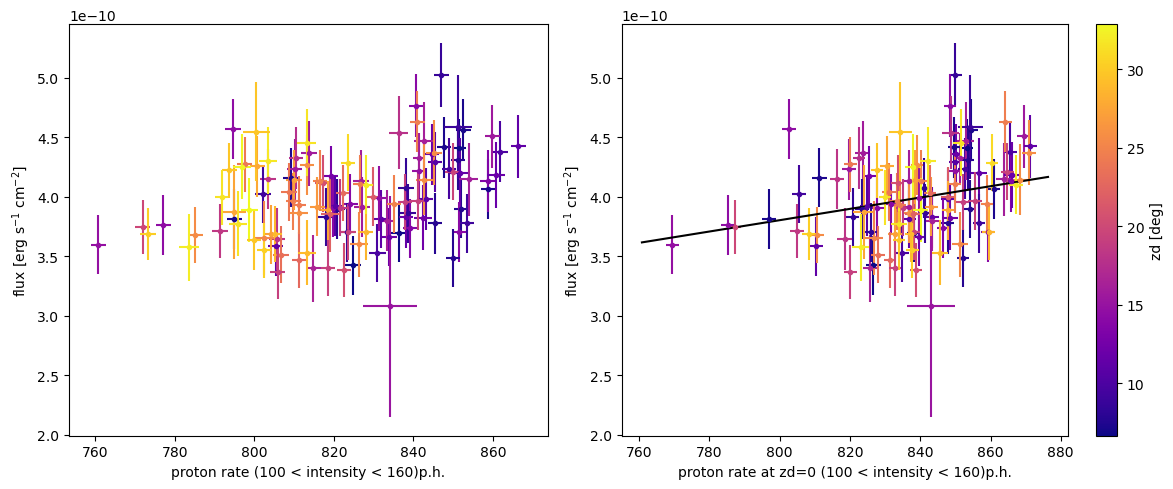

In [20]:
slope = np.dot(zd_0_p_rate, flux) / np.dot(zd_0_p_rate, zd_0_p_rate)

def fit_flux(x_value):
    return slope * x_value

for run in dict_runs.keys():
    _factor = fit_flux(dict_runs[run]["zd_0_p_rate"]) / dict_runs[run]["flux"]
    dict_runs[run]["zd_corr"] = _factor
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [1.2, 1.4]})


norm_zd   = mpl.colors.Normalize(vmin=np.min(zd), vmax=np.max(zd))
colors_zd = mpl.cm.ScalarMappable(norm_zd,"plasma").to_rgba(zd)

for i in range(len(az)):
    ax1.errorbar(p_rate[i],      flux[i], xerr=e_p_rate[i], yerr=e_flux[i], ls="", marker=".", color=colors_zd[i])
    ax2.errorbar(zd_0_p_rate[i], flux[i], xerr=e_p_rate[i], yerr=e_flux[i], ls="", marker=".", color=colors_zd[i])

#######################################
# creating a colorbar
sm_zd  = plt.cm.ScalarMappable(cmap="plasma", norm=norm_zd)
sm_zd.set_array([])
fig.colorbar(sm_zd, ax=ax2, label="zd [deg]")
#######################################

####################
p_array = np.linspace(min(p_rate), max(p_rate)+10, 200)
ax2.plot(p_array, fit_flux(p_array), '-k', label="Linear Fit")

ax1.set_ylabel("flux [erg s${}^{-1}$ cm${}^{-2}$]")
ax2.set_ylabel("flux [erg s${}^{-1}$ cm${}^{-2}$]")

ax1.set_xlabel(f"proton rate ({intensity_integration_lims[0]} < intensity < {intensity_integration_lims[1]})p.h.")
ax2.set_xlabel(f"proton rate at zd=0 ({intensity_integration_lims[0]} < intensity < {intensity_integration_lims[1]})p.h.")

fig.tight_layout()
plt.show()

### Applying the corrections to the flux

In [21]:
corr = "zd_corr"
zd_corr_flux = []
mean_flux = np.mean(flux) #fit_flux(np.mean(dict_runs[run]["zd_0_p_rate"]))

for run in dict_runs.keys():
    
    _zd_corr_flux = dict_runs[run]["flux"] - (fit_flux(dict_runs[run]["zd_0_p_rate"]) - mean_flux)
    zd_corr_flux.append(_zd_corr_flux)
    dict_runs[run]["zd_corr_flux"] = _zd_corr_flux

### Plotting the corrections

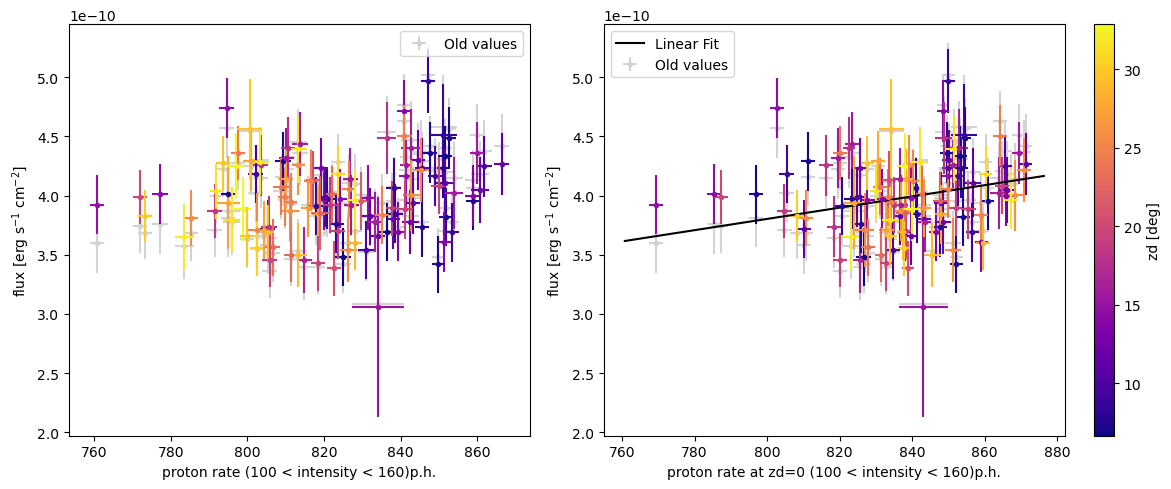

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [1.2, 1.5]})


norm_zd   = mpl.colors.Normalize(vmin=np.min(zd), vmax=np.max(zd))
colors_zd = mpl.cm.ScalarMappable(norm_zd,"plasma").to_rgba(zd)

for i in range(len(az)):
    ax1.errorbar(p_rate[i],      zd_corr_flux[i], xerr=e_p_rate[i], yerr=e_flux[i], ls="", marker=".", color=colors_zd[i])
    ax2.errorbar(zd_0_p_rate[i], zd_corr_flux[i], xerr=e_p_rate[i], yerr=e_flux[i], ls="", marker=".", color=colors_zd[i])
ax1.errorbar(p_rate,      flux, xerr=e_p_rate, yerr=e_flux, ls="", marker=".", color="lightgray", zorder=-10, label="Old values")
ax2.errorbar(zd_0_p_rate, flux, xerr=e_p_rate, yerr=e_flux, ls="", marker=".", color="lightgray", zorder=-10, label="Old values")

#######################################
# creating a colorbar
sm_zd  = plt.cm.ScalarMappable(cmap="plasma", norm=norm_zd)
sm_zd.set_array([])
fig.colorbar(sm_zd, ax=ax2, label="zd [deg]")
#######################################

# plot line
p_array = np.linspace(min(p_rate), max(p_rate)+10, 200)
ax2.plot(p_array, fit_flux(p_array), '-k', label="Linear Fit")


ax1.legend()
ax2.legend()
ax1.set_ylabel("flux [erg s${}^{-1}$ cm${}^{-2}$]")
ax2.set_ylabel("flux [erg s${}^{-1}$ cm${}^{-2}$]")
ax1.set_xlabel(f"proton rate ({intensity_integration_lims[0]} < intensity < {intensity_integration_lims[1]})p.h.")
ax2.set_xlabel(f"proton rate at zd=0 ({intensity_integration_lims[0]} < intensity < {intensity_integration_lims[1]})p.h.")

fig.tight_layout()
plt.show()

### Plotting the Light Curve

Flux original       = 3.986 ± 0.341   [e-10 erg / (s cm2)]
Flux zd correction  = 3.985 ± 0.321   [e-10 erg / (s cm2)]


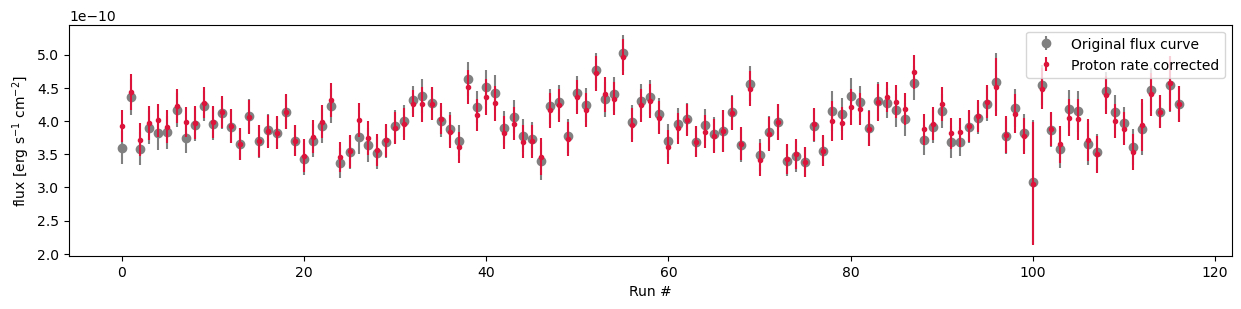

In [24]:
units = "[e-10 erg / (s cm2)]"
print(f"Flux original       = {np.mean(flux) * 1e10:.3f} ± {np.std(flux) * 1e10:.3f}   {units}")
print(f"Flux zd correction  = {np.mean(zd_corr_flux) * 1e10:.3f} ± {np.std(zd_corr_flux) * 1e10:.3f}   {units}")

fig, ax = plt.subplots(figsize=(15, 3))

for i, run in enumerate(dict_LC_2.keys()):  

    if i == 0:
        label = "Original flux curve"
        label_zd  = "Proton rate corrected"
    else:   
        label, label_zd = None, None
        
    errors = dict_runs[run]["e_flux"]
    flux_value         = dict_runs[run]["flux"]
    zd_corr_flux_value = dict_runs[run]["zd_corr_flux"]
    
    ax.errorbar(i, flux_value,         yerr=errors, marker="o", ls="", color="gray",  zorder=-10, label=label)
    ax.errorbar(i, zd_corr_flux_value, yerr=errors, marker=".", ls="", color="crimson", label=label_zd)

ax.legend()
ax.set_xlabel(f"Run #")
ax.set_ylabel("flux [erg s${}^{-1}$ cm${}^{-2}$]")
plt.show()

### Calculating the chi2 distributions

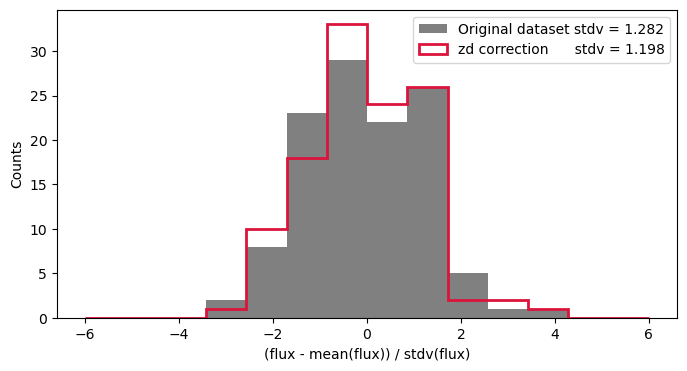

Original dataset  stdv = 1.282
zd correction     stdv = 1.198


In [25]:
chi2, zd_corr_chi2 = [], []

for run in dict_runs.keys():
    if run > 0:
        chi2.append((dict_runs[run]["flux"] - np.mean(flux)) / dict_runs[run]["e_flux"])
        zd_corr_chi2.append((dict_runs[run]["zd_corr_flux"] - np.mean(zd_corr_flux)) / dict_runs[run]["e_flux"])

bins = np.linspace(-6, 6, 15)

fig, ax = plt.subplots(figsize=(8, 4))

ax.hist(chi2,         bins=bins, color="gray", label=f"Original dataset stdv = {np.std(chi2):.3f}")
ax.hist(zd_corr_chi2, bins=bins, color="crimson", histtype="step", lw=2, label=f"zd correction      stdv = {np.std(zd_corr_chi2):.3f}")


ax.legend()
ax.set_ylabel("Counts")
ax.set_xlabel("(flux - mean(flux)) / stdv(flux)")
plt.show()

print(f"Original dataset  stdv = {np.std(chi2):.3f}")
print(f"zd correction     stdv = {np.std(zd_corr_chi2):.3f}")